# Create different versions of Embeddings

## Version control

- V4 settings
    - VAE with Inception modules

## Interpretation of v.4 (VAE with Inception modules)
- aaa


In [1]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import itertools
import copy
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors

# images
# import cv2
from PIL import Image
import matplotlib.pyplot as plt

# pytorch
import torch
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader, random_split
import gc

In [2]:
def plot_images(path, character_ids):
    # just show first 10 images in 2x5 frame. This method could be made flexible, but there's no need
    rows, columns = 2, 5
    imgs = []
    character_ids = character_ids[:10+1]

    # get the actual images
    for id in character_ids:
        img = Image.open(path + str(id) + ".png")
        imgs.append(np.array(img))

    # iterate over axis and show
    fig, axes = plt.subplots(rows, columns, figsize=(8,4))
    for img, ax in zip(imgs, axes.flatten()):
        ax.imshow(img, cmap="gray")
    plt.show()

---
## Data Prep
---

In [3]:
# # quick preparation of trial data
# img_list = os.listdir("../assets/character_images/character_images/")
# for img in tqdm(img_list[:501]):
#     try:
#         grey_img = Image.open("../assets/character_images/character_images/"+img).convert("L")
#         grey_img.save("../assets/character_images/character_images_grayscale_test/"+img)
#     except:
#         print("error at: ", img)

In [4]:
# check file count
print(len(os.listdir("../assets/character_images/character_images_grayscale_test/")))

500


In [5]:
class MangaDataset(Dataset):

    def __init__(self, target_dir, transform_steps=None):
        self.target_dir = target_dir
        self.transform_steps = transform_steps
        self.target_imgs = os.listdir(target_dir)

    def __len__(self):
        return len(self.target_imgs)

    def __getitem__(self, idx):
        img_path = os.path.join(self.target_dir, self.target_imgs[idx])
        img = Image.open(img_path)

        if self.transform_steps:
            tensor_img = self.transform_steps(img)

        character_id = self.target_imgs[idx].split(".")[0]
        # first is input to the model, second is input for reconstruction, third is the character_id for future ref
        return tensor_img, tensor_img, character_id

In [6]:
# # Define transformations and initialize Dataset
# transform_steps = transforms.Compose([transforms.ToTensor(),
#                                       transforms.CenterCrop(200),
#                                       transforms.Normalize(mean=[0], std=[1.0])
#                                      ])
# manga_dataset = MangaDataset("../assets/character_images/character_images_grayscale_test", transform_steps)

In [7]:
# # Set DataLoader

# # Split train and data
# train_size = int(manga_dataset.__len__() * 0.75)
# val_size = int(manga_dataset.__len__() - train_size)
# train_dataset, val_dataset = random_split(manga_dataset, [train_size, val_size]) 

# # Data loaders
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=32)

# # All dataloader
# all_data_loader = DataLoader(manga_dataset, batch_size=32)

In [8]:
# # Check Dataset
# img_ex = train_dataset.__getitem__(0)
# print(len(img_ex))
# print(type(img_ex))
# print(img_ex[0].shape)

# # Check DataLoader
# input_tensor, output_tensor, character_id = next(iter(train_loader))
# print(f"input batch shape: {input_tensor.size()}")
# print(f"output batch shape: {output_tensor.size()}")
# img_ex = input_tensor[0].squeeze()
# plt.imshow(img_ex, cmap="gray")
# plt.show()

In [78]:
# set the steps as a function
def prep_data(data_path, transform_steps, train_ratio, batch_size):
    manga_dataset = MangaDataset(data_path, transform_steps)
    train_size = int(manga_dataset.__len__() * train_ratio)
    val_size = int(manga_dataset.__len__() - train_size)
    train_dataset, val_dataset = random_split(manga_dataset, [train_size, val_size]) 
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    all_data_loader = DataLoader(manga_dataset, batch_size=batch_size)
    return train_loader, val_loader, all_data_loader

---
## VAE with Inception modules
---

In [79]:
# Codes to build individual modules

# encoder modules
def single_encoder_module(in_c, out_c, k, s=1, p=0):
    module = nn.Sequential(nn.Conv2d(in_c, out_c, kernel_size=k, stride=s, padding=p),
                           nn.BatchNorm2d(out_c),
                           nn.ReLU(inplace=True))
    return module

def single_downsampling_module(in_c, pooling):
    module = nn.Sequential(nn.AvgPool2d(pooling),
                           nn.Conv2d(in_c, in_c*2, kernel_size=1),
                           nn.BatchNorm2d(in_c*2),
                           nn.ReLU(inplace=True))
    return module


# decoder modules
def single_decoder_module(in_c, out_c, k, s=1, p=0, op=0):
    module = nn.Sequential(nn.ConvTranspose2d(in_c, out_c, kernel_size=k, stride=s, padding=p, output_padding=op),
                           nn.BatchNorm2d(out_c),
                           nn.ReLU(inplace=True))
    return module

def single_upsampling_module(in_c, pooling, op=0):
    module = nn.Sequential(nn.ConvTranspose2d(in_c, in_c//2, kernel_size=pooling, stride=pooling, output_padding=op),
                           nn.BatchNorm2d(in_c//2),
                           nn.ReLU(inplace=True))
    return module

def single_upsampling_module_custom(in_c, out_c, k=1, s=1, p=0, op=0):
    module = nn.Sequential(nn.ConvTranspose2d(in_c, out_c, kernel_size=k, stride=s, padding=p, output_padding=op),
                           nn.BatchNorm2d(out_c),
                           nn.ReLU(inplace=True))
    return module

In [80]:
# Inception modules

class EncoderInceptionModule(nn.Module):
    def __init__(self, channels):
        super().__init__()
        bn_ch = channels // 2
        self.bottleneck = single_encoder_module(channels, bn_ch, 1)
        self.conv1 = single_encoder_module(bn_ch, channels, 1)
        self.conv2 = single_encoder_module(bn_ch, channels, 3, p=1)
        self.conv3 = single_encoder_module(bn_ch, channels, 5, p=2)
        self.conv4 = single_encoder_module(bn_ch, channels, 7, p=3)
        self.pool1 = nn.MaxPool2d(3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(5, stride=1, padding=2)

    def forward(self, x):
        bn = self.bottleneck(x)
        out = self.conv1(bn) + self.conv2(bn) + self.conv3(bn) + self.conv4(bn) + self.pool1(x) + self.pool2(x)
        return out


class DecoderInceptionModule(nn.Module):
    def __init__(self, channels):
        super().__init__()
        bn_ch = channels // 4
        self.bottleneck = single_decoder_module(channels, bn_ch, 1)
        self.deconv1 = single_decoder_module(bn_ch, channels, 1)
        self.deconv2 = single_decoder_module(bn_ch, channels, 3, p=1)
        self.deconv3 = single_decoder_module(bn_ch, channels, 5, p=2)
        self.deconv4 = single_decoder_module(bn_ch, channels, 7, p=3)
        self.pool1 = nn.MaxPool2d(3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(5, stride=1, padding=2)

    def forward(self, x):
        bn = self.bottleneck(x)
        out = self.deconv1(bn) + self.deconv2(bn) + self.deconv3(bn) + self.deconv4(bn) + self.pool1(x) + self.pool2(x)
        return out

In [81]:
# Encoder and decoder modules
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.up_ch1 = nn.Conv2d(1, 32, kernel_size=1)
        self.e_incep1 = EncoderInceptionModule(32)
        self.up_ch2 = single_downsampling_module(32, 4)
        self.e_incep2 = EncoderInceptionModule(64)
        self.up_ch3 = single_downsampling_module(64, 4)
        self.e_incep3 = EncoderInceptionModule(128)
        self.up_ch4 = single_downsampling_module(128, 2)
        self.e_incep4 = EncoderInceptionModule(256)

    def forward(self, x):
        out = self.e_incep1(self.up_ch1(x))
        out = self.e_incep2(self.up_ch2(out))
        out = self.e_incep3(self.up_ch3(out))
        out = self.e_incep4(self.up_ch4(out))
        out = F.avg_pool2d(out, 6)
        return out.view(-1, 256)


class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.d_incep1 = DecoderInceptionModule(256)
        self.down_ch1 = single_upsampling_module(256, 2)
        self.d_incep2 = DecoderInceptionModule(128)
        self.down_ch2 = single_upsampling_module(128, 4)
        self.d_incep3 = DecoderInceptionModule(64)
        # self.down_ch3 = single_upsampling_module(64, 4)
        self.down_ch3 = single_upsampling_module_custom(64, 32, k=5, s=3)
        self.down_ch4 = single_upsampling_module_custom(32, 32, k=7, s=1)
        self.d_incep4 = DecoderInceptionModule(32)
        self.last = nn.ConvTranspose2d(32, 1, kernel_size=1)

    def forward(self, x):
        out = F.interpolate(x.view(-1, 256, 1, 1), scale_factor=8)
        out = self.down_ch1(self.d_incep1(out))
        out = self.down_ch2(self.d_incep2(out))
        out = self.down_ch3(self.d_incep3(out))
        out = self.down_ch4(out)
        out = self.d_incep4(out)
        out = self.last(out)
        return torch.sigmoid(out)

In [82]:
# VAE model: pretty much the same as model v3 
class VAE(nn.Module):

    def __init__(self, device):
        super().__init__()
        self.device = device
        
        self.encoder = Encoder()
        self.fc_mu = nn.Linear(256, 64)
        self.fc_logvar = nn.Linear(256, 64)
        self.fc_rep = nn.Linear(64, 256)
        self.decoder = Decoder()

    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        esp = torch.randn(*mu.size()).to(self.device)
        z = mu + std * esp
        return z

    def bottleneck(self, h):
        mu, log_var = self.fc_mu(h), self.fc_logvar(h)
        z = self.reparameterize(mu, log_var)
        return z, mu, log_var

    def forward(self, x):
        h = self.encoder(x)
        z, mu, log_var = self.bottleneck(h)
        z = self.fc_rep(z)
        d = self.decoder(z)
        return d, mu, log_var

In [83]:
# custom loss function
def bce_kld_loss(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction="sum")
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

---
## Test runs
---

In [71]:
# !nvidia-smi

In [72]:
# import sys
# def sizeof_fmt(num, suffix='B'):
#     for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
#         if abs(num) < 1024.0:
#             return "%3.1f %s%s" % (num, unit, suffix)
#         num /= 1024.0
#     return "%.1f %s%s" % (num, 'Yi', suffix)

# for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
#                          key= lambda x: -x[1])[:10]:
#     print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

In [73]:
# empty gpu cache
torch.cuda.empty_cache()

In [74]:
# test VAE
transform_steps = transforms.Compose([transforms.ToTensor(),
                                      transforms.CenterCrop(200),
                                      #transforms.RandomRotation(90),
                                      #transforms.RandomHorizontalFlip(),
                                      #transforms.Normalize(mean=[0], std=[1.0])
                                     ])
train_loader, val_loader, all_data_loader = prep_data("../assets/character_images/character_images_grayscale_test", 
                                                      transform_steps=transform_steps, train_ratio=0.8, batch_size=8)

# initialize again, set to train mode, send models to gpu
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = "cpu"
print(device)
model = VAE(device=device)
model.train()
model.to(device)

# set loss function, optimizer
vae_params = list(model.parameters())
optimizer = optim.Adam(vae_params, lr=0.005)

# train
losses = []

for epoch in tqdm(range(10)):
    running_loss = 0.0
    for counter, (train_img, target_img, _) in enumerate(train_loader, 1):
        train_img = train_img.to(device)
        target_img = target_img.to(device)

        optimizer.zero_grad()
        z, mu, log_var = model(train_img)
        # print(type(z), type(target_img))

        # loss = kldiv(z, target_img)
        loss = bce_kld_loss(z, target_img, mu, log_var)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # clean up
        del train_img, target_img, z, mu, log_var, loss
        gc.collect()
    avg_loss = running_loss / counter
    losses.append(avg_loss)

cuda


  0%|                                                                                   | 0/10 [00:00<?, ?it/s]

torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8,

 10%|███████▌                                                                   | 1/10 [00:34<05:14, 34.93s/it]

torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8,

 20%|███████████████                                                            | 2/10 [01:08<04:31, 33.90s/it]

torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8,

 30%|██████████████████████▌                                                    | 3/10 [01:41<03:56, 33.78s/it]

torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8,

 40%|██████████████████████████████                                             | 4/10 [02:15<03:23, 33.92s/it]

torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8,

 50%|█████████████████████████████████████▌                                     | 5/10 [02:49<02:49, 33.84s/it]

torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8,

 60%|█████████████████████████████████████████████                              | 6/10 [03:23<02:15, 33.95s/it]

torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8,

 70%|████████████████████████████████████████████████████▌                      | 7/10 [03:57<01:41, 33.88s/it]

torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8,

 80%|████████████████████████████████████████████████████████████               | 8/10 [04:31<01:08, 34.07s/it]

torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8,

 90%|███████████████████████████████████████████████████████████████████▌       | 9/10 [05:05<00:33, 33.95s/it]

torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8,

100%|██████████████████████████████████████████████████████████████████████████| 10/10 [05:39<00:00, 33.97s/it]


In [ ]:
!nvidia-smi
# !kill -9 12547

[36055313710.93969, 261900.461875, 638222.3028125, 237091.4071875, 222746.4521875, 229578.5003125, 232621.29, 222954.95125, 219216.381875, 214170.21]


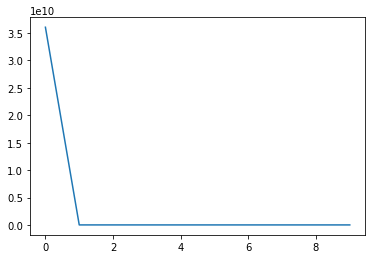

In [75]:
# quick plot of training losses
plt.plot(losses)
print(losses)

In [76]:
model.eval()

# validate
val_losses = []

for epoch in tqdm(range(10)):
    with torch.no_grad():
        running_loss = 0.0
        for counter, (train_img, target_img, _) in enumerate(val_loader, 1):
            train_img = train_img.to(device)
            target_img = target_img.to(device)

            # forward
            z, mu, log_var = model(train_img)

            # calculate loss
            loss = bce_kld_loss(z, target_img, mu, log_var)
            running_loss += loss.item()
        avg_loss = running_loss / counter
        val_losses.append(avg_loss)

  0%|                                                                                   | 0/10 [00:00<?, ?it/s]

torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])


 10%|███████▌                                                                   | 1/10 [00:02<00:23,  2.61s/it]

torch.Size([4, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([4, 1, 200, 200])


 20%|███████████████                                                            | 2/10 [00:04<00:19,  2.46s/it]

torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])


 30%|██████████████████████▌                                                    | 3/10 [00:07<00:16,  2.41s/it]

torch.Size([4, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([4, 1, 200, 200])


 40%|██████████████████████████████                                             | 4/10 [00:09<00:14,  2.38s/it]

torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])


 50%|█████████████████████████████████████▌                                     | 5/10 [00:11<00:11,  2.37s/it]

torch.Size([4, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([4, 1, 200, 200])


 60%|█████████████████████████████████████████████                              | 6/10 [00:14<00:09,  2.37s/it]

torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])


 70%|████████████████████████████████████████████████████▌                      | 7/10 [00:16<00:07,  2.36s/it]

torch.Size([4, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([4, 1, 200, 200])


 80%|████████████████████████████████████████████████████████████               | 8/10 [00:19<00:04,  2.36s/it]

torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])


 90%|███████████████████████████████████████████████████████████████████▌       | 9/10 [00:21<00:02,  2.36s/it]

torch.Size([4, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([8, 1, 200, 200])
torch.Size([4, 1, 200, 200])


100%|██████████████████████████████████████████████████████████████████████████| 10/10 [00:23<00:00,  2.38s/it]


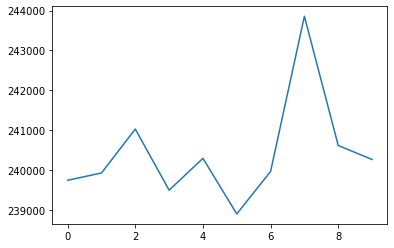

In [77]:
# quick plot of training losses
plt.plot(val_losses)

---
## Train
---

In [86]:
# !nvidia-smi

In [91]:
# version setting
version = "v4"

In [92]:
# Putting training and validation into methods
def train_step(model, train_loader, optimizer, device):
    model.train()

    running_loss = 0.0
    for counter, (train_img, target_img, _) in enumerate(train_loader, 1):
        train_img = train_img.to(device)
        target_img = target_img.to(device)

        optimizer.zero_grad()
        z, mu, log_var = model(train_img)

        loss = bce_kld_loss(z, target_img, mu, log_var)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # clean up
        del train_img, target_img, z, mu, log_var, loss
        gc.collect()

    avg_loss = running_loss / counter
    return avg_loss


def val_step(model, val_loader, device):
    model.eval()

    running_loss = 0.0
    with torch.no_grad():
        for counter, (train_img, target_img, _) in enumerate(val_loader, 1):
            train_img = train_img.to(device)
            target_img = target_img.to(device)

            # forward
            z, mu, log_var = model(train_img)

            # calculate loss
            loss = bce_kld_loss(z, target_img, mu, log_var)
            running_loss += loss.item()
            
            # clean up
            del train_img, target_img, z, mu, log_var, loss
            gc.collect()

        avg_loss = running_loss / counter
        return avg_loss

In [93]:
# empty gpu cache
torch.cuda.empty_cache()

In [94]:
# train and validate to check that the methods work

# redo the settings all again

# set data
# better with batch_size=64 rather than 32 (32 can end up with training curve not going down)
transform_steps = transforms.Compose([transforms.ToTensor(),
                                      transforms.CenterCrop(200),
                                      # transforms.RandomRotation(90),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.Normalize(mean=[0], std=[1.0])
                                     ])
train_loader, val_loader, all_data_loader = prep_data("../assets/character_images/character_images_grayscale_test", 
                                                      transform_steps=transform_steps, train_ratio=0.8, batch_size=8)

# initialize again, set to train mode, send models to gpu
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = "cpu"
print(device)
model = VAE(device=device)
model.train()
model.to(device)

# set loss function, optimizer
vae_params = list(model.parameters())
optimizer = optim.Adam(vae_params, lr=0.005)

# check that it works
EPOCHS = 20
train_losses = []
val_losses = []
min_loss = 1e5

for epoch in tqdm(range(1, EPOCHS+1)):
    train_loss = train_step(model, train_loader, optimizer, device=device)
    train_losses.append(train_loss)
    # print(f"Epochs = {epoch}, Training Loss : {train_loss}")

    val_loss = val_step(model, val_loader, device=device)
    val_losses.append(val_loss)
    # print(f"Epochs = {epoch}, Validation Loss : {val_loss}")

    # Save the best model
    if val_loss < min_loss:
        best_vae = copy.deepcopy(model)
        torch.save(best_vae.state_dict(), "../assets/character_images/models_and_embeddings/vae_model_"+version+".pt")
        min_loss = val_loss
        

cuda


100%|██████████████████████████████████████████████████████████████████████████| 20/20 [12:32<00:00, 37.61s/it]


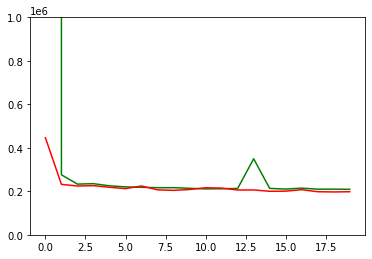

In [95]:
# plot training & validation losses
# print(train_losses[0:10])
plt.plot(train_losses,"g", val_losses, "r")
plt.ylim(0.0, 1000000)
plt.show()

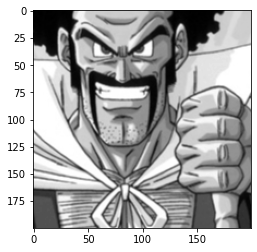

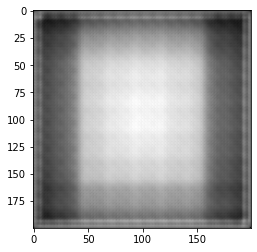

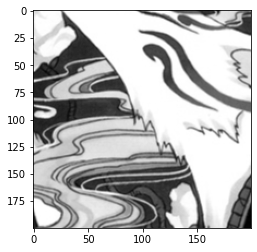

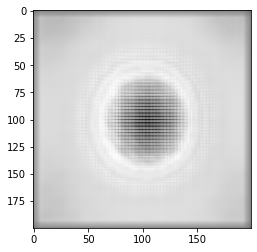

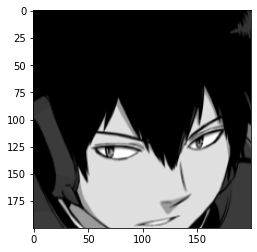

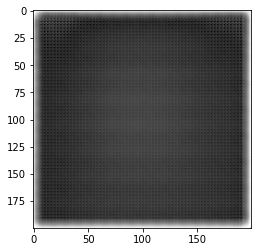

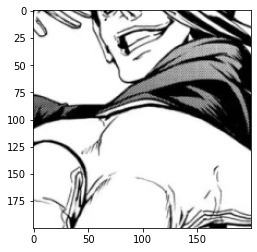

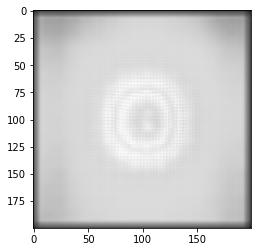

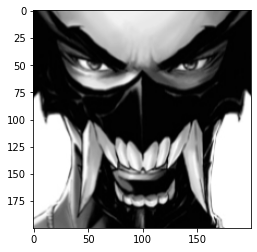

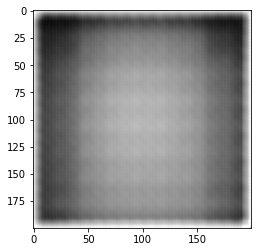

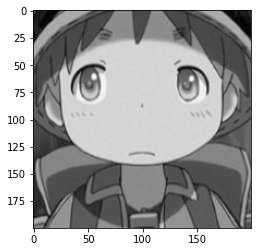

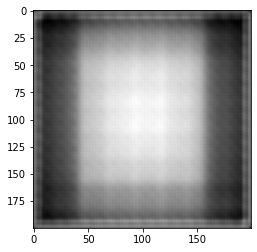

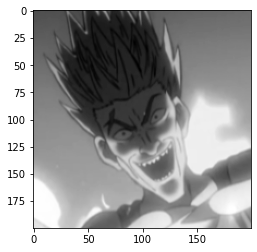

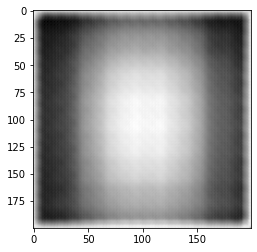

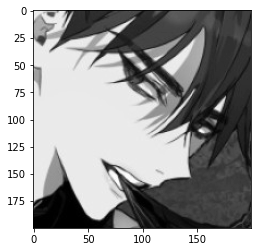

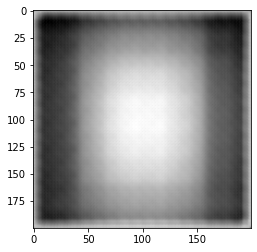

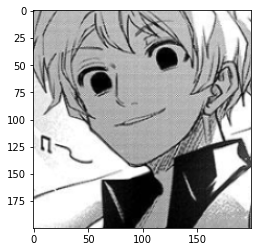

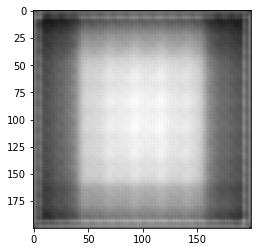

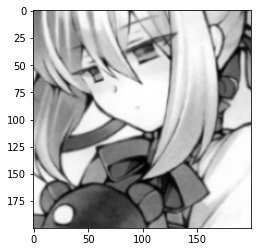

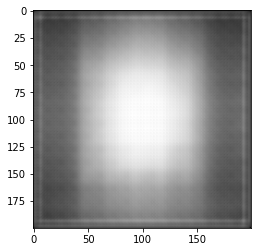

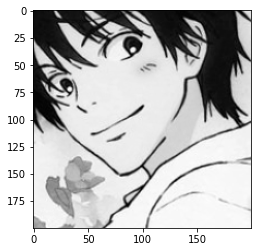

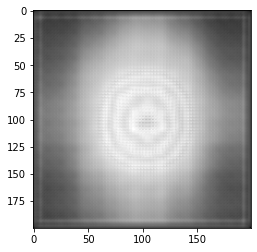

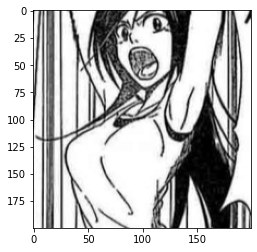

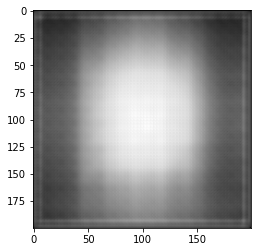

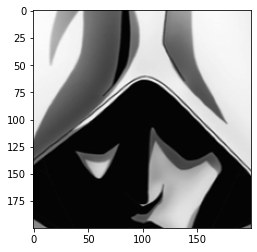

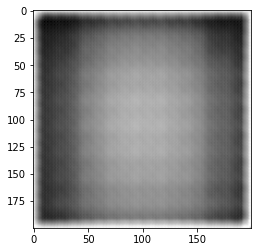

In [96]:
# show what the model learned -> look how validation images are now represented by the decoder
# if the model learned the images well, they should look similar to each other

# Note: 
# when training loss doesn't go down (10 epochs, ~0.4 loss at minimum) -> dec_output is all BLACK and can't see anything
# when training loss goes down (50 epochs, ~0.04) -> dec_output is blurry but somewhat similar to the input

model.eval()
with torch.no_grad():
    for train_img, target_img, _ in val_loader:
        
        train_img = train_img.to(device)
        target_img = target_img.to(device)
        z, mu, log_var = model(train_img)
        
        # show only the first image of each batch (output original and decoder output images for comparison)
        for t_img, out_img in zip(train_img[0], z[0]):
            plt.imshow(t_img.detach().cpu().numpy().squeeze(), cmap="gray")
            plt.show()
            plt.imshow(out_img.detach().cpu().numpy().squeeze(), cmap="gray")
            plt.show()

---
## Create embedding
---

In [99]:
# create embedding

model.eval()
embedding = torch.zeros((1, 256))
character_ids = []
with torch.no_grad():
    for train_img, target_img, character_id in tqdm(all_data_loader):
        train_img = train_img.to(device)
        h = model.encoder(train_img)
        h = h.cpu()
        # print(z.shape)
        # enc_output = encoder(train_img).cpu()
        embedding = torch.cat((embedding, h), 0)
        character_ids.append(character_id)

In [100]:
# Convert to numpy and save
character_ids = list(itertools.chain.from_iterable(character_ids))
np_character_ids = np.array(character_ids)
embedding = embedding[1:, :]
print("len of character_ids: ", len(character_ids))
print("shape of embedding: ", embedding.shape)
np_embedding = embedding.cpu().detach().numpy()
num_images = np_embedding.shape[0]

# Save the embeddings
flattened_embedding = np_embedding.reshape((num_images, -1))
print("shape of flattened embedding: ", flattened_embedding.shape)
np.save("../assets/character_images/models_and_embeddings/image_embedding_"+version+".npy", flattened_embedding)
np.save("../assets/character_images/models_and_embeddings/image_embedding_character_ids_"+version+".npy", np_character_ids)

len of character_ids:  500
shape of embedding:  torch.Size([500, 256])
shape of flattened embedding:  (500, 256)


---
## Similarity calculations (Character-based, Title-based)
---

In [101]:
class ImageBasedRecommendation:
    def __init__(self, query_path, version):
        print("model version: ", version)
        self.embedding_flat_np = np.load("../assets/character_images/models_and_embeddings/image_embedding_"+version+".npy") 
        self.embedding_ids = np.load("../assets/character_images/models_and_embeddings/image_embedding_character_ids_"+version+".npy") 
        self.df_characters = pd.read_csv("../assets/characters_200p.csv")
        self.query_path = query_path

        # create character_based similarity matrix
        self.df_chara_sim_mat = pd.DataFrame(cosine_similarity(self.embedding_flat_np))
        self.df_chara_sim_mat.index = self.embedding_ids
        self.df_chara_sim_mat.columns = self.embedding_ids

        # create title_based similarity matrix
        np_embedding_id_concat = np.c_[self.embedding_ids.astype(int), self.embedding_flat_np] # create character_id:embeddings table
        df_embedding = pd.DataFrame(np_embedding_id_concat)
        df_embedding.rename(columns={0:"character_id"}, inplace=True)
        df_characters_unique = self.df_characters.drop_duplicates(subset="character_id") 
        df_title_char = df_characters_unique[["title_id", "character_id"]] # get character:title reference table
        df_merged = pd.merge(df_title_char, df_embedding, how="inner", on="character_id")
        df_title_embedding_avg = df_merged.groupby("title_id").mean() # merge and calculate "average" of image features
        self.df_title_sim_mat = pd.DataFrame(cosine_similarity(df_title_embedding_avg.iloc[:, 1:])) # similarity calculation of titles
        self.df_title_sim_mat.index = df_title_embedding_avg.index
        self.df_title_sim_mat.columns = df_title_embedding_avg.index

    def recommend_titles_from_similar_characters(self, query_character_id, top_n):
        # show the querying character
        df_q = self.df_characters[self.df_characters["character_id"]==query_character_id]
        print("Queried character: ", df_q["character_name"].unique(), " who appears in: ", df_q["title_romaji"].unique())
        img = Image.open(self.query_path + str(query_character_id) + ".png")
        plt.imshow(np.array(img), cmap="gray")
        plt.show()

        # get similar character
        df = self.df_chara_sim_mat[str(query_character_id)].sort_values(ascending=False)
        df_top = df[1:top_n+1]
        top_ids = list(df_top.index.astype(int))
        plot_images(self.query_path, top_ids)
        
        # print character names
        print("Similar characters (in the order of appearance)")
        for chara_id in top_ids:
            df_recc = self.df_characters[self.df_characters["character_id"]==int(chara_id)]
            print("Character: ", df_recc["character_name"].unique(), " who appears in : ", df_recc["title_romaji"].unique())

        # get titles that each similar character appears in
        df_res = self.df_characters[self.df_characters["character_id"].isin(top_ids)]
        df_res = df_res.drop_duplicates(subset="character_name")
        recc_title_ids = df_res["title_id"].unique()
        
        return recc_title_ids

    def recommend_titles_from_similar_image_embedding(self, query_title_id, top_n):
        # query title and pull out similar titles
        df = self.df_title_sim_mat[query_title_id].sort_values(ascending=False)
        df_top = df[0:top_n+1]
        top_ids = df_top.index

        # get images for comparison
        for idx, id in enumerate(top_ids):
            df = self.df_characters[self.df_characters["title_id"]==id]
            if idx == 0:
                print("Querying title: ", df["title_romaji"].unique())
            else:
                print("Similar title: ", df["title_romaji"].unique())
            character_ids = df["character_id"].unique()
            plot_images(self.query_path, character_ids)

        return list(top_ids[1:]) # exclude first element as it's the queried title


model version:  v4
Queried character:  ['Jirou Azuma']  who appears in:  ['BLACK TORCH']


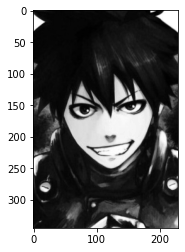

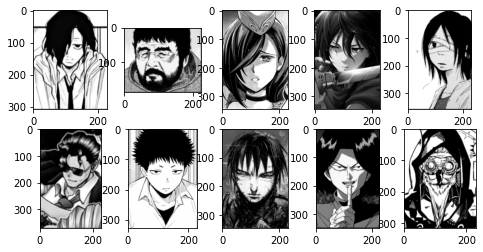

Similar characters (in the order of appearance)
Character:  ['Seiji  Hotokeyama']  who appears in :  ['Yozakura-san Chi no Daisakusen']
Character:  ['Mr. Ita']  who appears in :  ['Homunculus']
Character:  ['Hrist']  who appears in :  ['Shuumatsu no Valkyrie']
Character:  ['Mikasa Ackerman']  who appears in :  ['Shingeki no Kyojin' 'Shingeki no Kyojin: LOST GIRLS'
 'Shingeki! Kyojin Chuugakkou' 'Sungeki no Kyojin'
 'Shingeki! Kyojin Chuugakkou: Seishun! Tonari no Marley Gakuen']
Character:  ['Kyoko Sakaki']  who appears in :  ['Nijigahara Holograph']
Character:  ['Billy']  who appears in :  ['Undead Unluck']
Character:  ['Medaka Kuroiwa']  who appears in :  ['Kuroiwa Medaka ni Watashi no Kawaii ga Tsuujinai']
Character:  ['Killy']  who appears in :  ['BLAME!' 'NOiSE' 'Blame! Gakuen And So On' 'BLAME!²'
 'Blame!: Denki Ryoushi Kiken Kaisou Dasshutsu Sakusen' 'BLAME']
Character:  ['Rishou']  who appears in :  ['Yuu☆Yuu☆Hakusho']
Character:  ['Kako']  who appears in :  ['Jibaku Shounen Ha

In [102]:
ibr_search = ImageBasedRecommendation("../assets/character_images/character_images_grayscale/", "v4")
res = ibr_search.recommend_titles_from_similar_characters(query_character_id=137304, top_n=10)
print(res)

Querying title:  ['Berserk']


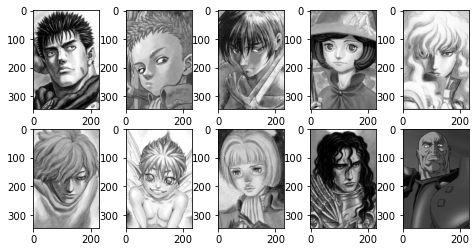

Similar title:  ['Kingdom']


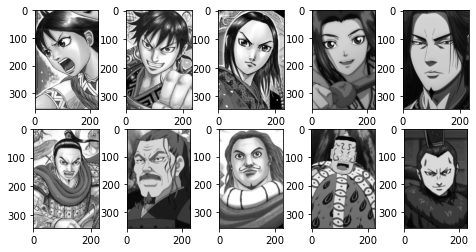

Similar title:  ['Bokura wa Minna Kawaisou']


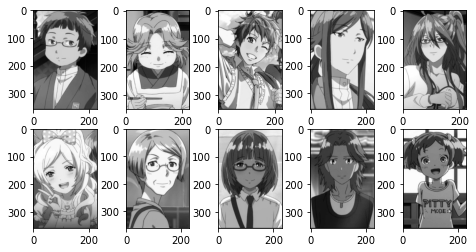

Similar title:  ['Tate no Yuusha no Nariagari']


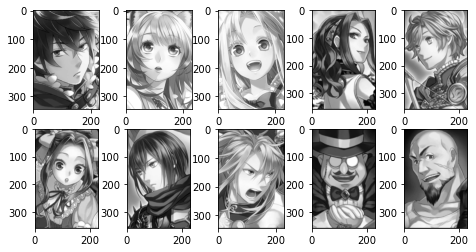

[46765, 56769, 85442]


In [103]:
res = ibr_search.recommend_titles_from_similar_image_embedding(query_title_id=30002, top_n=3)
print(res)